In [1]:
import numpy as np
import pandas as pd
import os
import random

import lightgbm as lgb

In [2]:
input_path = '../datasets/'

In [16]:
log_df = pd.read_csv(os.path.join(input_path, 'carlog.csv'))
meta_df = pd.read_csv(os.path.join(input_path, 'meta.csv'))
test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))
product_master_df = pd.read_csv(os.path.join(input_path, 'product_master.csv'))
user_master_df = pd.read_csv(os.path.join(input_path, 'user_master.csv'))
sample_submission_df = pd.read_csv(os.path.join(input_path, 'atmaCup#9__sample_submission.csv'))

train_Y = pd.read_csv('../output/train_Y.csv')
test_Y = pd.read_csv('../output/test_Y.csv')

# Feature Engineering

In [22]:
# join user_id
train_df = pd.merge(train_Y, meta_df[['session_id', 'user_id']], on='session_id', how='left')
train_df = pd.merge(train_df, user_master_df, on='user_id', how='left')
train_df.head()

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768,user_id,age,gender
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bE94Gct4vGiKM7z2Y79cjk,40.0,1.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,V4bEuaKPEPoK8MswqPksvK,30.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ntRurFKVWYBQR86auef5Fc,50.0,1.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,GhHaHMCyrz76y2dCeVXfbn,30.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,kG58HejrEcbjJQ7JojRSay,30.0,1.0


In [23]:
feature_cols = ['age',     'gender']
categorical_columns =  ['gender']

print(feature_cols)

['age', 'gender']


In [24]:
train_Y.tail()

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768
739445,795929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739446,795930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739447,795931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739448,795934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739449,795935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train

In [28]:
target_category = [38, 110, 113, 114, 134, 171, 172, 173, 376, 435, 467, 537, 539, 629, 768]
target_category_str = [str(col) for col in target_category]

In [29]:
params = {
'num_leaves': 300,
'max_bin':450,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
'objective': 'binary',
'learning_rate': 0.05,
'bagging_freq': 10,
'bagging_fraction': 0.5,
"boosting_type": "rf",
"metric": 'auc',
'random_state': 47
}

params = {
'num_leaves': 300,
'max_bin':450,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
'objective': 'binary',
'learning_rate': 0.05,
"boosting_type": "gbdt",
"metric": 'auc',
'random_state': 47
}

In [30]:
target_col = '38'
print('*'*30)
true_ids = list(train_Y[train_Y[target_col]==1].session_id.unique())
false_ids = list(train_Y[train_Y[target_col]!=1].session_id.unique())
print(target_col, len(true_ids), len(false_ids))

false_ids = random.sample(false_ids, len(true_ids)) # down samplling
sampleing_ids = true_ids + false_ids

train_idx = random.sample(sampleing_ids, int(len(sampleing_ids) * 0.7))
val_idx = list(set(sampleing_ids) - set(train_idx))

assert set(train_idx) & set(val_idx) == set()
train_X = train_df[train_df.session_id.isin(train_idx)]
train_y = train_Y[train_Y.session_id.isin(train_idx)]

valid_X = train_df[train_df.session_id.isin(val_idx)].reset_index()
valid_y = train_Y[train_Y.session_id.isin(val_idx)].reset_index()
print('train & valid: ', len(train_X), len(valid_X))

******************************
38 40492 698958
train & valid:  56688 24296


In [33]:
models = []

for target_col in target_category_str:
    print('*'*30)
    true_ids = list(train_Y[train_Y[target_col]==1].session_id.unique())
    false_ids = list(train_Y[train_Y[target_col]!=1].session_id.unique())
    print(target_col, len(true_ids), len(false_ids))
    
    false_ids = random.sample(false_ids, len(true_ids)) # down samplling
    sampleing_ids = true_ids + false_ids
    
    train_idx = random.sample(sampleing_ids, int(len(sampleing_ids) * 0.8))
    val_idx = list(set(sampleing_ids) - set(train_idx))
    
    assert set(train_idx) & set(val_idx) == set()
    train_X = train_df[train_df.session_id.isin(train_idx)]
    train_y = train_Y[train_Y.session_id.isin(train_idx)]

    valid_X = train_df[train_df.session_id.isin(val_idx)].reset_index()
    valid_y = train_Y[train_Y.session_id.isin(val_idx)].reset_index()
    print('train & valid: ', len(train_X), len(valid_X))
    
    tr_data = lgb.Dataset(train_X[feature_cols], label=train_y[target_col], feature_name=feature_cols)
    va_data = lgb.Dataset(valid_X[feature_cols], label=valid_y[target_col], feature_name=feature_cols)
    del train_X, train_y, valid_X, valid_y
    
    model = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=feature_cols,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
     # _ = lgb.plot_importance(model)
    models.append(model)
#     del tr_data, va_data

******************************
38 40492 698958
train & valid:  64787 16197
[LightGBM] [Info] Number of positive: 32396, number of negative: 32391
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 64787, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500039 -> initscore=0.000154
[LightGBM] [Info] Start training from score 0.000154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

113 19471 719979
train & valid:  31153 7789
[LightGBM] [Info] Number of positive: 15571, number of negative: 15582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 31153, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499823 -> initscore=-0.000706
[LightGBM] [Info] Start training from score -0.000706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[11]	training's auc: 0.554049	valid_1's auc: 0.549447
******************************
171 49050 690400
train & valid:  78480 19620
[LightGBM] [Info] Number of positive: 39243, number of negative: 39237
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train 

173 58149 681301
train & valid:  93038 23260
[LightGBM] [Info] Number of positive: 46388, number of negative: 46650
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 93038, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498592 -> initscore=-0.005632
[LightGBM] [Info] Start training from score -0.005632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[16]	training's auc: 0.532041	valid_1's auc: 0.526156
******************************
467 14942 724508
train & valid:  23907 5977
[LightGBM] [Info] Number of positive: 11996, number of negative: 11911
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[17]	training's auc: 0.551642	valid_1's auc: 0.564371
***********

768 58712 680738
train & valid:  93939 23485
[LightGBM] [Info] Number of positive: 46903, number of negative: 47036
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 93939, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499292 -> initscore=-0.002832
[LightGBM] [Info] Start training from score -0.002832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [34]:
tmp = [0.516074, 0.564352, 0.56227, 0.564371, 0.535603, 0.526156, 0.531664, 0.547229, 0.54011, 0.561125, 0.549447, 0.579677, 0.570102, 0.51857, 0.553342, ]
print(len(tmp))
print(sum(tmp) / len(tmp))

15
0.5480061333333334


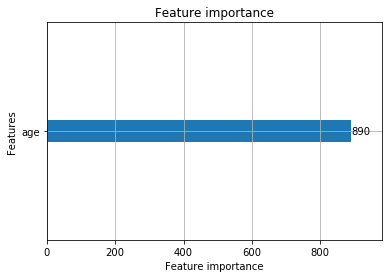

In [36]:
_ = lgb.plot_importance(models[7])

# Inference

In [37]:
# make feature
agg = feature_df.groupby('user_id')[target_category_str].agg(['sum', 'count'])

cols = []
for col in target_category_str:
    cols.append(col + '_sum')
    cols.append(col + '_count')
agg.columns = cols

for col in target_category_str:
    k = col + '_avg'
    agg[k]= agg[col + '_sum'] / agg[col + '_count']
    agg.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

agg = agg.reset_index()

agg = pd.merge(agg, user_master_df, on='user_id', how='left')

agg.head()

,user_id,38_avg,110_avg,113_avg,114_avg,134_avg,171_avg,172_avg,173_avg,376_avg,435_avg,467_avg,537_avg,539_avg,629_avg,768_avg,age,gender
0,222BJXjf8z6YfvHVLvjbhK,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.375000,0.000000,0.0,0.0,0.625,0.000000,0.0,0.125000,40.0,0.0
1,2285uFEmqQNtttDNKPc7Zh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.0,0.000000,30.0,1.0
2,22CVr2MdbLSkbXycnChGQd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000,0.000000,0.0,0.000000,30.0,0.0
3,22KGbCvUqtWPXFsdeCWnrQ,0.250000,0.083333,0.000000,0.416667,0.083333,0.000000,0.0,0.000000,0.166667,0.0,0.0,0.000,0.000000,0.0,0.083333,70.0,9.0
4,22Ls5VMp7g4mNGfTn2QQ2c,0.101124,0.000000,0.033708,0.162921,0.134831,0.011236,0.0,0.005618,0.011236,0.0,0.0,0.000,0.005618,0.0,0.022472,30.0,0.0


In [39]:
# これ少しあかん
# go_df = train_df.groupby('user_id')[['go_flg']].max().reset_index()
# agg = pd.merge(agg, go_df, on='user_id', how='left')
# agg.head()

In [41]:
test_session_user_df = pd.merge(test_df, meta_df[['session_id', 'user_id']], on='session_id', how='left')
test_X = pd.merge(test_session_user_df, agg, on='user_id', how='left')

test_X = test_X[feature_cols]
test_X.fillna(-1, inplace=True) # 初めて & ユーザー情報に紐づかない人
test_X.head()

,age,gender
0,50.0,0.0
1,40.0,0.0
2,50.0,0.0
3,50.0,0.0
4,60.0,0.0


In [42]:
len(test_session_user_df)

56486

In [43]:
len(test_df)

56486

In [44]:
len(test_X)

56486

In [45]:
for model, col in zip(models, target_category_str):
    test_df[col] = model.predict(test_X)
test_df.head()

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768
0,663721,0.498203,0.536575,0.502850,0.491087,0.476695,0.517840,0.515358,0.525351,0.523253,0.538436,0.553262,0.500936,0.562694,0.513394,0.523651
1,663725,0.531906,0.512533,0.538044,0.565885,0.547038,0.545407,0.514652,0.523518,0.511110,0.479582,0.508106,0.520282,0.524827,0.503319,0.505565
2,663737,0.498203,0.536575,0.502850,0.491087,0.476695,0.517840,0.515358,0.525351,0.523253,0.538436,0.553262,0.500936,0.562694,0.513394,0.523651
3,663745,0.498203,0.536575,0.502850,0.491087,0.476695,0.517840,0.515358,0.525351,0.523253,0.538436,0.553262,0.500936,0.562694,0.513394,0.523651
4,663747,0.438854,0.451027,0.396606,0.373137,0.445918,0.427287,0.506705,0.533539,0.541047,0.514736,0.470173,0.554288,0.492591,0.551544,0.493268


In [46]:
test_df.drop('session_id', axis=1, inplace=True)

In [47]:
test_df.round(5).to_csv('../output/submission.csv', index=None)